#**Data Analysis for Horror Movie Ratings Ratio data**

In [73]:
# general 
import pandas as pd 
import numpy as np 
from datetime import datetime

# stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import mean_squared_error

# data processing
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# prediction model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 10)

In [74]:
genre = "horror"

In [75]:
# reads the data
df = pd.read_csv(genre + "AnalysisData.csv")
df['date'] = pd.to_datetime(df.apply(lambda x: datetime.strptime(f"{int(x['year'])}-{int(x['month'])}", '%Y-%m').date(), axis=1))
df = df.drop(columns = ['month', 'year'])
df = df.set_index("date").asfreq('MS')

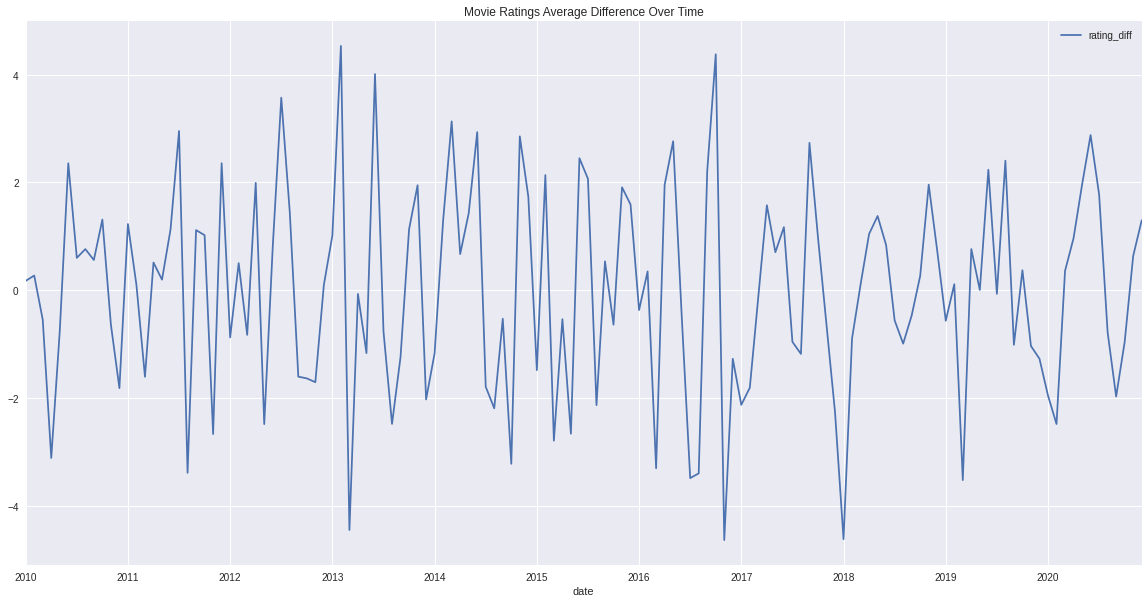

In [76]:
# regular plot
df.plot(y='rating_diff', 
        title='Movie Ratings Average Difference Over Time',
        figsize = (20, 10));

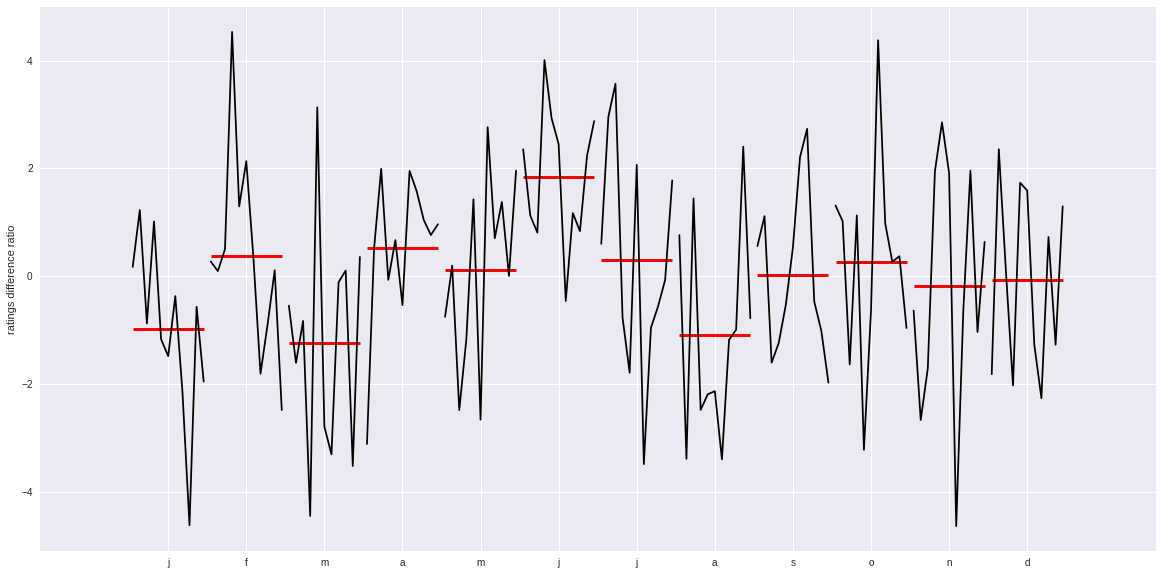

In [77]:
# month plot
plt.rc("figure", figsize=(20,10))
df.index = pd.DatetimeIndex(df.index, freq='MS')
month_plot(df["rating_diff"], ylabel='ratings difference ratio');

In [78]:
# perform adfuller test to see the statistics of the data

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF: ", dftest[0])
    print("2. P-Value: ", dftest[1])
    print("3. Num of Lags: ", dftest[2])
    print("4. Num of Observation Used For ADF Regression and Critical Values of Calculation: ", dftest[3])
    print("5. Critical Values: ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)
    return dftest

In [79]:
ad_test(df['rating_diff'])

1. ADF:  -8.538467532739771
2. P-Value:  9.931006078332687e-14
3. Num of Lags:  3
4. Num of Observation Used For ADF Regression and Critical Values of Calculation:  128
5. Critical Values: 
	 1% :  -3.4825006939887997
	 5% :  -2.884397984161377
	 10% :  -2.578960197753906


(-8.538467532739771,
 9.931006078332687e-14,
 3,
 128,
 {'1%': -3.4825006939887997,
  '10%': -2.578960197753906,
  '5%': -2.884397984161377},
 490.91688661178057)

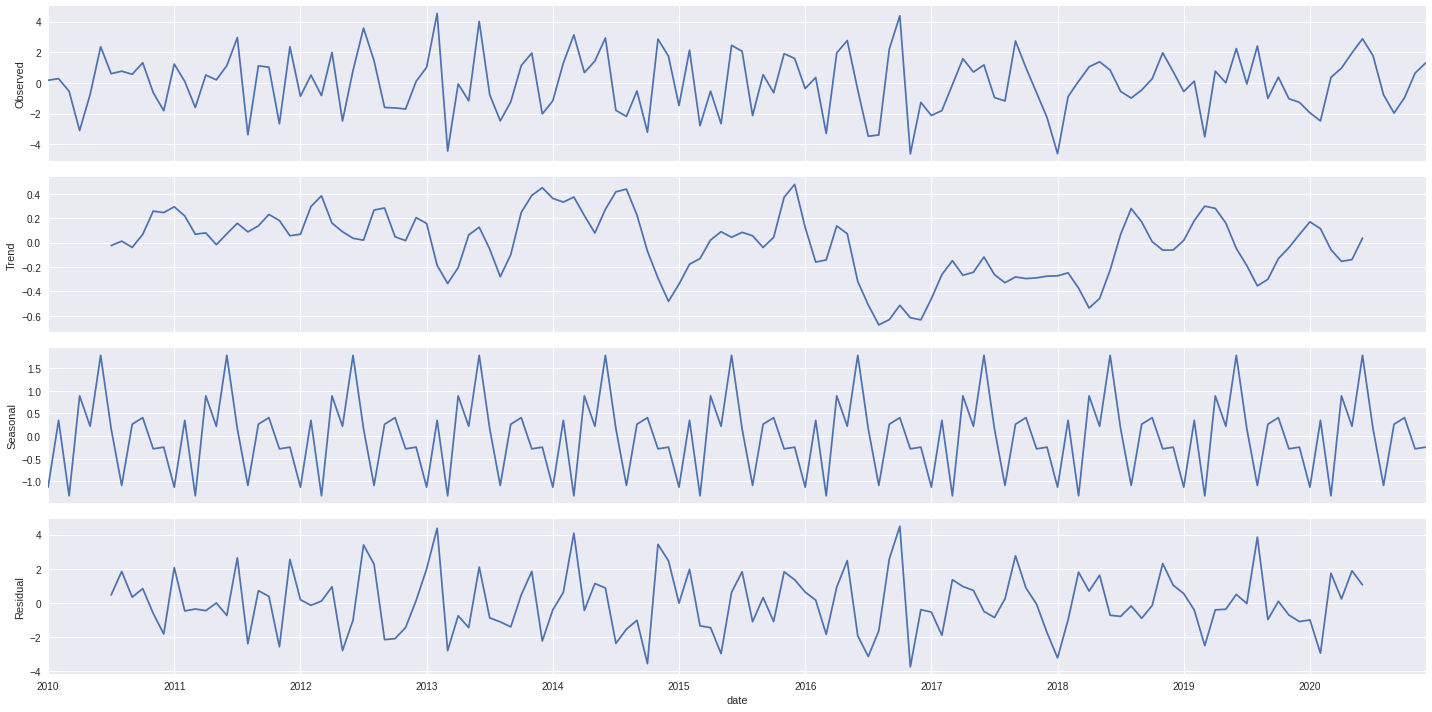

In [80]:
decompose = seasonal_decompose(df['rating_diff'])
decompose.plot();

In [81]:
# get the training data which is the values of the datas
train = df.iloc[:]

# convert the data into decimal numbers between 0 and 1 for the data
# to have a small magnitude

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

# define the generator:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [82]:
for i in range(2021, 2026):
  tf.keras.backend.clear_session()
  model = Sequential()
  model.add(LSTM(100, activation = 'relu', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  # fit the model for each year prediction
  model.fit(generator, epochs=350)

  # used to store the current year prediction
  test_predictions = []
  first_eval_batch = scaled_train[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for j in range(12):
    # get the prediction valur for the first batch.
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)
  
  scaled_train = (np.append(scaled_train, test_predictions)).reshape(((len(scaled_train) + n_input), n_features))
  
  # generate a new generator for the model to train again based on the new years prediction
  generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

Epoch 1/350
120/120 [==============================] - 2s 7ms/step - loss: 0.0850
Epoch 2/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0509
Epoch 3/350
120/120 [==============================] - 1s 7ms/step - loss: 0.0522
Epoch 4/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0549
Epoch 5/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0501
Epoch 6/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0510
Epoch 7/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0505
Epoch 8/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0535
Epoch 9/350
120/120 [==============================] - 1s 7ms/step - loss: 0.0498
Epoch 10/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0511
Epoch 11/350
120/120 [==============================] - 1s 6ms/step - loss: 0.0500
Epoch 12/350
120/120 [==============================] - 1s 7ms/step - loss: 0.0479
Epoch 13/350


In [83]:
predicted_data = scaler.inverse_transform(scaled_train[-60:])
start = 0
end = 12
for year in range(2021, 2026):
      df1 = pd.DataFrame()
      df1['month'] = [1,2,3,4,5,6,7,8,9,10,11,12]
      df1['year'] = [year for m in range(12)]
      df1['rating_diff'] = predicted_data[start:end]
      df1['date'] = pd.to_datetime(df1.apply(lambda x: datetime.strptime(f"{int(x['year'])}-{int(x['month'])}", '%Y-%m').date(), axis=1))
      df1 = df1.drop(columns = ['month', 'year'])
      df1 = df1.set_index("date").asfreq('MS')
      df = df.append(df1)
      start += 12
      end += 12

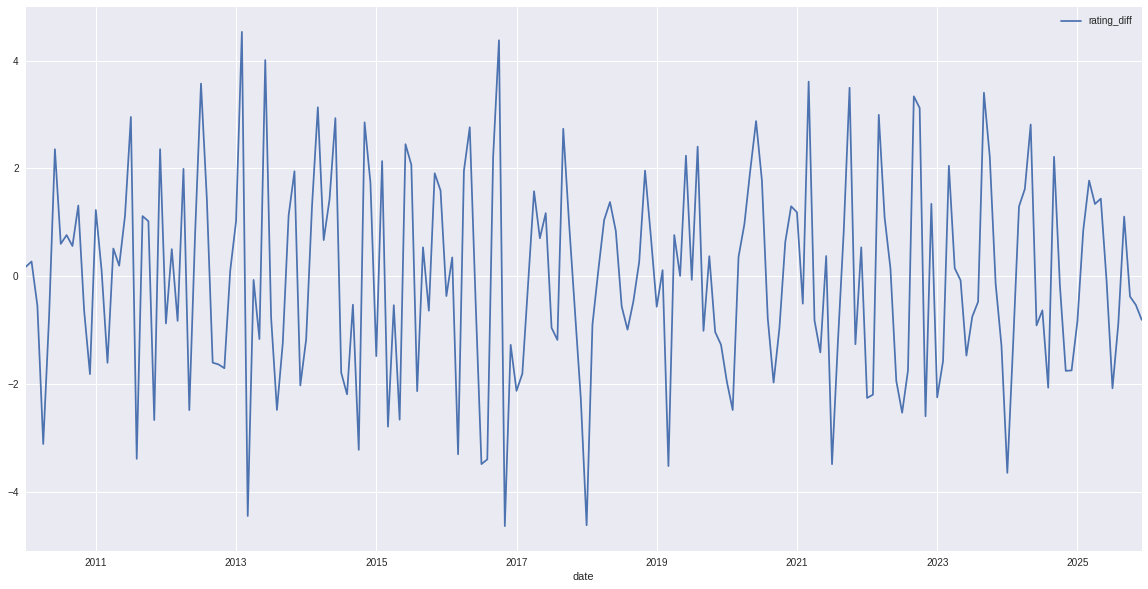

In [84]:
df.plot()

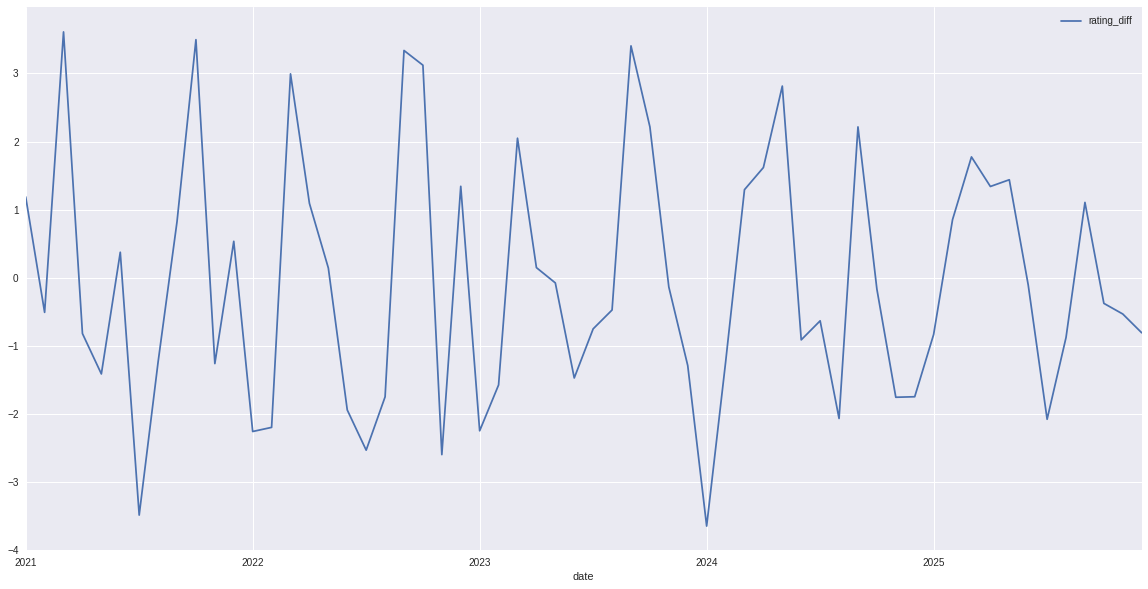

In [91]:
newdf = df.iloc[-60:]
newdf.to_csv("final_prediction_2021-2025_LSTM.csv")
newdf.plot()

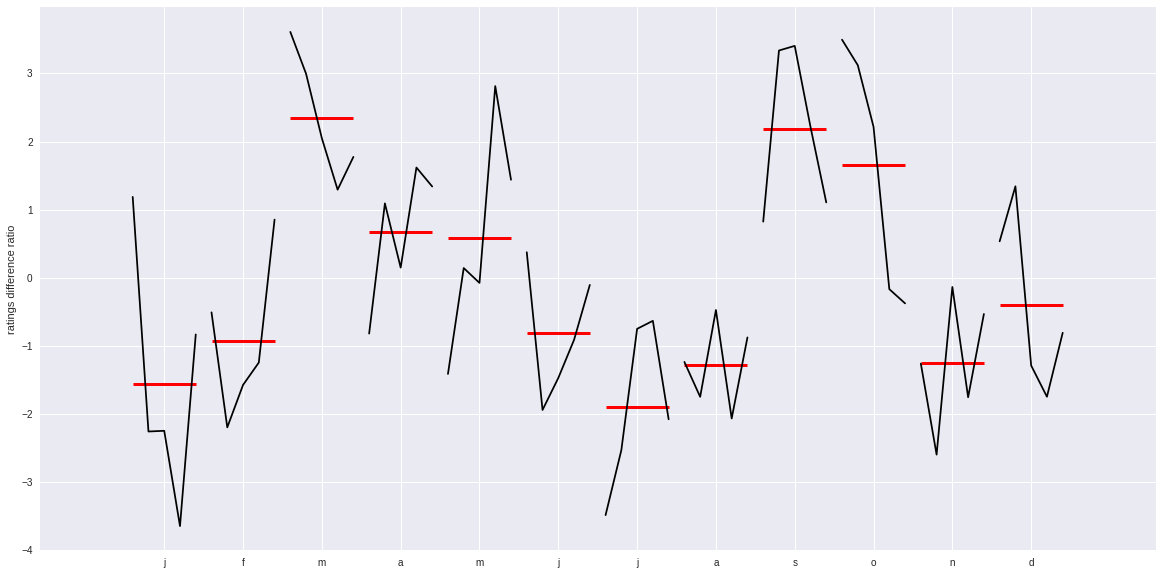

In [92]:
# month plot
plt.rc("figure", figsize=(20,10))
month_plot(newdf["rating_diff"], ylabel='ratings difference ratio');

In [89]:
# read the file to be processed
df = pd.read_csv("final_prediction_2021-2025_LSTM.csv")
df = df.set_index("date").asfreq('MS')
df['month'] = df.index.month
df.reset_index(drop=True, inplace=True)

# make a new dataframe for the analysis
test = pd.DataFrame()
test['jan'] = np.array(df[df['month'] == 1]['rating_diff'])
test['feb'] = np.array(df[df['month'] == 2]['rating_diff'])
test['mar'] = np.array(df[df['month'] == 3]['rating_diff'])
test['apr'] = np.array(df[df['month'] == 4]['rating_diff'])
test['may'] = np.array(df[df['month'] == 5]['rating_diff'])
test['jun'] = np.array(df[df['month'] == 6]['rating_diff'])
test['jul'] = np.array(df[df['month'] == 7]['rating_diff'])
test['aug'] = np.array(df[df['month'] == 8]['rating_diff'])
test['sep'] = np.array(df[df['month'] == 9]['rating_diff'])
test['oct'] = np.array(df[df['month'] == 10]['rating_diff'])
test['nov'] = np.array(df[df['month'] == 11]['rating_diff'])
test['dec'] = np.array(df[df['month'] == 12]['rating_diff'])

1. ADF:  -2.0577168100207097
2. P-Value:  0.2618530732115315
3. Num of Lags:  11
4. Num of Observation Used For ADF Regression and Critical Values of Calculation:  48
5. Critical Values: 
	 1% :  -3.5745892596209488
	 5% :  -2.9239543084490744
	 10% :  -2.6000391840277777


(-2.0577168100207097,
 0.2618530732115315,
 11,
 48,
 {'1%': -3.5745892596209488,
  '10%': -2.6000391840277777,
  '5%': -2.9239543084490744},
 151.3375568805248)